# Dry Bean Dataset Classification and SVM Kernel Visualizations

**Authors**
Eli Kaustinen and Gabriel Marcelino

**Dataset Description:**  
This notebook uses the [Dry Bean Dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset) from the UCI Machine Learning Repository. This dataset contains more than 10 attributes (features) and over 10,000 instances (13611 instances) of dry beans, where each instance is characterized by features (such as Area, Perimeter, MajorAxisLength, etc.) and the target variable `Class` (which specifies one of several bean types).

**Assignment Requirements:**  
For this exercise, we implement two classification methods:
- k‑Nearest Neighbours (kNN)
- Support Vector Machine (SVM) (using the RBF kernel)

We will:
1. Load the appropriate packages.
2. Pre-process and subset the data.
3. Split the data into training and testing sets.
4. Build the classification models.
5. Run the models (make predictions).
6. Display quantitative and visual classification results.
7. Provide the confusion matrix for each classifier.
8. Compute accuracy, sensitivity (recall), specificity (and also precision and F1 score for completeness).
9. Explain the use of the ROC curve and the meaning of its area (AUC).
10. Compare the results of the classifiers and discuss any differences.

**Note on ROC Curves for Multiclass Problems:**  
ROC curves are most common in binary classification. In multiclass problems (as is the case with the Dry Bean dataset), one can compute ROC curves in a one‑vs‑rest framework. In this notebook, we provide an explanation of ROC curves and AUC, but for clarity, we focus our visual evaluations on confusion matrices and macro‑averaged metrics.
  
Before proceeding, we set Pandas options so that our DataFrame outputs are not truncated.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Pandas options to display all columns and a reasonable number of rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For data preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# For evaluation metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, classification_report)

# For synthetic data (for decision boundary visualization)
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap

## Part 1: Classification on the Dry Bean Dataset

We now load and pre-process the Dry Bean dataset. This dataset is a multiclass problem with a target variable called `Class`.

In [5]:
# Load the Dry Bean dataset
# Make sure the file "Dry_Bean_Dataset.csv" is in your working directory.
df = pd.read_csv('Dry_Bean_Dataset.csv')

# Display the first few rows of the dataset
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())

Dataset Head:
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272751  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358  

### 1.1 Data Preprocessing

- **Handling Missing Values:**  
  We fill missing values only for the numeric columns. This prevents errors when attempting to compute means on non‑numeric data.
  
- **Feature Scaling:**  
  We standardize features as both kNN and SVM are sensitive to feature scale.
  
- **Subsetting the Data:**  
  We assume that all columns except `Class` are features.

In [6]:
# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Separate features and target. (Adjust column names if necessary.)
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.2 Split the Data into Training and Testing Sets

We use an 80/20 split and stratify on the target variable to maintain class proportions.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### 1.3 Build the Classification Models

We implement two classifiers:
1. **k‑Nearest Neighbours (kNN):** with k=5.
2. **Support Vector Machine (SVM):** using the RBF kernel.

#### Model 1: k‑Nearest Neighbours (kNN)

In [8]:
# Build kNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#### Model 2: Support Vector Machine (SVM)

We build an SVM using an RBF kernel. Note that non-linear kernels may require longer training time on very large datasets, but the Dry Bean dataset is of moderate size.

In [9]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_svm = svm_rbf.predict(X_test)

### 1.4 Evaluate the Models

Because this is a multiclass classification problem, we calculate evaluation metrics using macro‑averaging. The metrics computed include:

- **Accuracy:** Overall correctness.
- **Precision (Macro):** Average precision across classes.
- **Recall/Sensitivity (Macro):** Average recall across classes.
- **F1 Score (Macro):** Harmonic mean of precision and recall.
- **Specificity (Macro):** Average true negative rate across classes (computed using a one‑vs‑rest approach).

The confusion matrix is also displayed.

Below is a function to evaluate and print these metrics.

In [10]:
def evaluate_model(y_true, y_pred, model_name='Model'):
    cm = confusion_matrix(y_true, y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    # For specificity in a multiclass setting, compute one-vs-rest specificity per class and average them.
    cm_sum = cm.sum()
    specificity_list = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm_sum - (TP + FN + FP)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_list.append(specificity)
    specificity_macro = np.mean(specificity_list)
    
    print(f"--- {model_name} Evaluation ---")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (Macro): {precision:.3f}")
    print(f"Recall (Sensitivity, Macro): {recall:.3f}")
    print(f"Specificity (Macro): {specificity_macro:.3f}")
    print(f"F1 Score (Macro): {f1:.3f}\n")
    
    return cm, accuracy, precision, recall, f1, specificity_macro

print("kNN Model Evaluation:")
cm_knn, acc_knn, prec_knn, rec_knn, f1_knn, spec_knn = evaluate_model(y_test, y_pred_knn, model_name='kNN')

print("SVM (RBF Kernel) Model Evaluation:")
cm_svm, acc_svm, prec_svm, rec_svm, f1_svm, spec_svm = evaluate_model(y_test, y_pred_svm, model_name='SVM_RBF')

kNN Model Evaluation:
--- kNN Evaluation ---
Confusion Matrix:
[[232   0  21   0   1   3   8]
 [  0 104   0   0   0   0   0]
 [  8   0 308   0   6   2   2]
 [  0   0   0 646   0  10  53]
 [  0   0   6   6 366   0   8]
 [  2   0   1   7   0 383  13]
 [  2   0   0  51  11   5 458]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.88      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       326
    DERMASON       0.91      0.91      0.91       709
       HOROZ       0.95      0.95      0.95       386
       SEKER       0.95      0.94      0.95       406
        SIRA       0.85      0.87      0.86       527

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723

Accuracy: 0.917
Precision (Macro): 0.932
Recall (Sensitivity, Macro): 0.927
Specificity (Macro): 0

#### Explanation of ROC Curve and AUC (for Binary Classification)

The **ROC (Receiver Operating Characteristic) curve** is a plot that illustrates the performance of a binary classifier as its discrimination threshold is varied. It plots the **True Positive Rate (Recall)** against the **False Positive Rate (1 - Specificity)** for various thresholds.

- **Area Under the Curve (AUC):**  
  The AUC is a single scalar value that summarizes the ROC curve. An AUC of 1 indicates perfect classification, while an AUC of 0.5 suggests no discriminative power (equivalent to random guessing).

*Note:* In multiclass settings, computing ROC curves requires a one‑vs‑rest approach, and the interpretation becomes more involved. In this notebook, we focus on the confusion matrix and macro‑averaged metrics for evaluation.

#### Comparison of Classifiers

After evaluating both models, compare:
- **Confusion Matrices:** Check the distribution of errors.
- **Accuracy, Precision, Recall, Specificity, and F1 Score:** Determine which classifier performs better overall.
- If the results differ significantly, factors such as model assumptions (instance‑based vs. margin‑based), hyperparameter settings, and data characteristics may be responsible.
- If results are similar, consider other factors such as computational efficiency, interpretability, and ease of tuning.
  
---

## Part 2: Visualizing SVM Decision Boundaries with Different Kernel Functions

To illustrate how different SVM kernels form decision boundaries, we now generate a synthetic 2D dataset (using `make_moons`) and train several SVM models with various kernels:

1. **Linear Kernel:**  
   - Straight-line decision boundaries.
2. **Gaussian RBF Kernel:**  
   - Smooth, flexible boundaries. Gamma controls the tightness.
3. **Polynomial Kernel:**  
   - *Homogeneous (coef0=0):* Boundary passes through the origin.
   - *Inhomogeneous (coef0≠0):* Boundary is shifted.
4. **Sigmoid Kernel:**  
   - Decision boundary similar to logistic regression.

The following code trains and plots the decision boundaries.

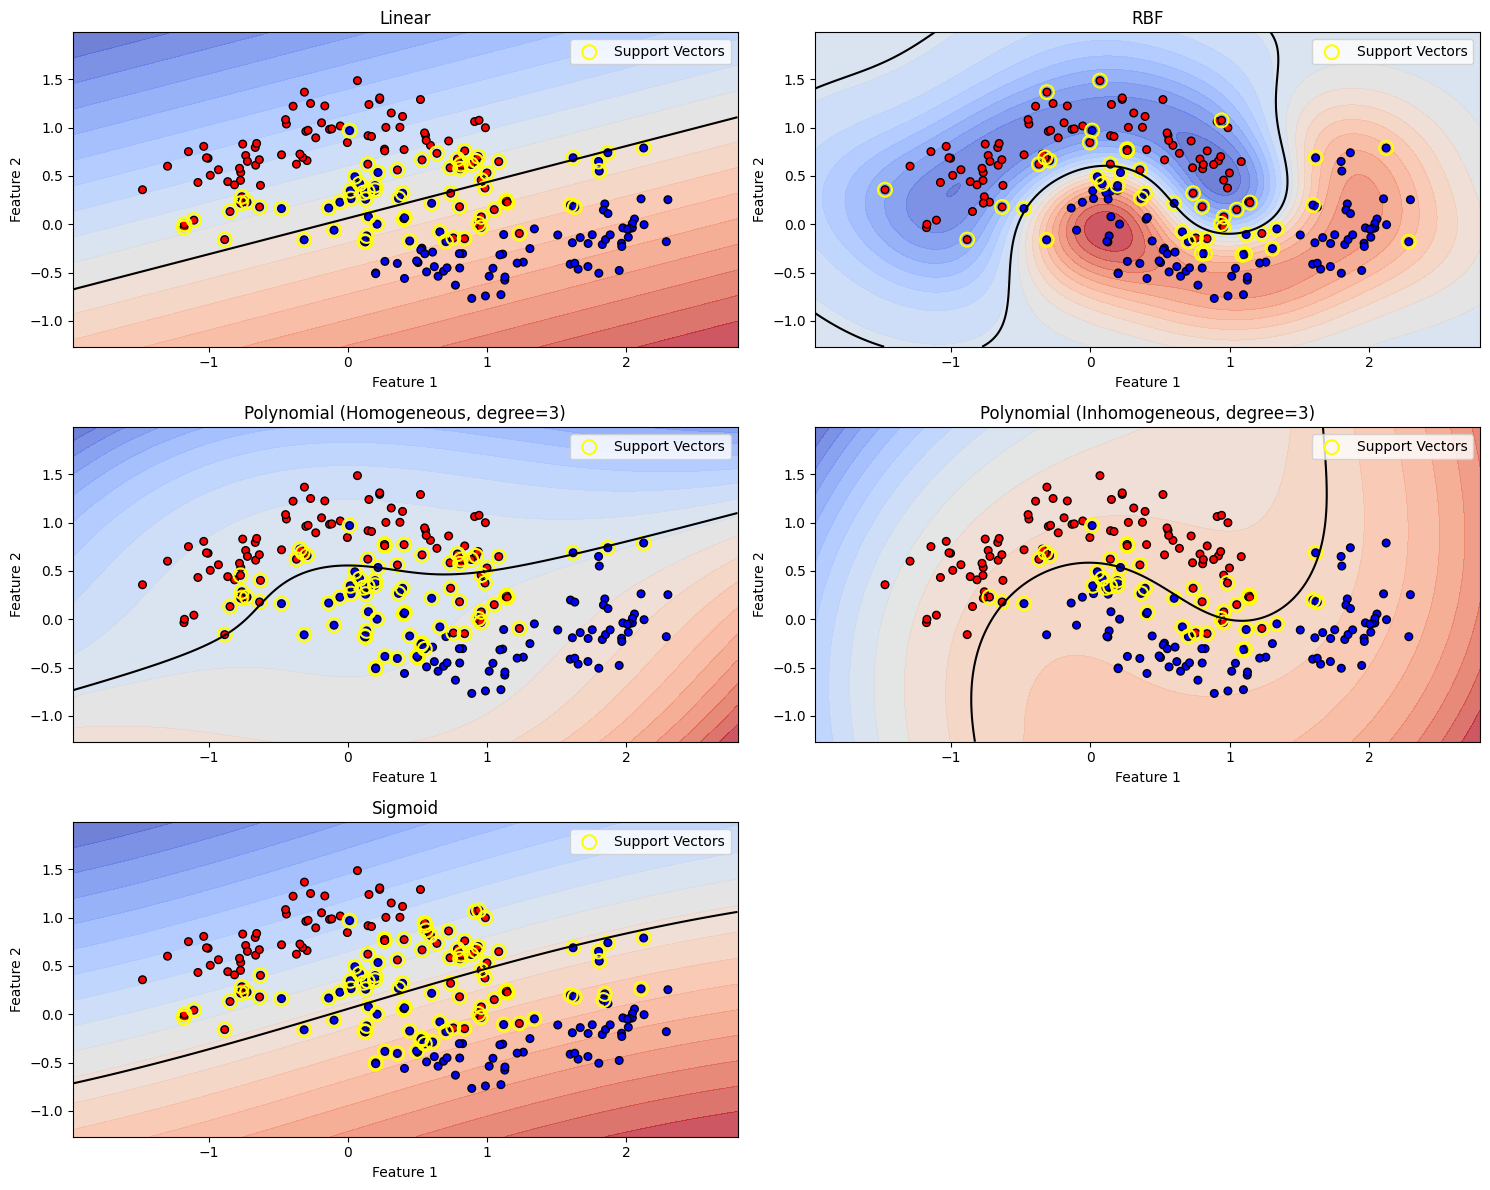

In [11]:
# Generate a synthetic 2D dataset for visualization
X_syn, y_syn = make_moons(n_samples=200, noise=0.20, random_state=42)

# Define a mesh grid to plot decision boundaries
x_min, x_max = X_syn[:, 0].min() - 0.5, X_syn[:, 0].max() + 0.5
y_min, y_max = X_syn[:, 1].min() - 0.5, X_syn[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Define SVM kernel settings
kernel_settings = {
    'Linear': {'kernel': 'linear'},
    'RBF': {'kernel': 'rbf', 'gamma': 2},
    'Polynomial (Homogeneous, degree=3)': {'kernel': 'poly', 'degree': 3, 'coef0': 0},
    'Polynomial (Inhomogeneous, degree=3)': {'kernel': 'poly', 'degree': 3, 'coef0': 1},
    'Sigmoid': {'kernel': 'sigmoid', 'gamma': 0.1, 'coef0': 0.0}
}

plt.figure(figsize=(15, 12))
i = 1
for name, params in kernel_settings.items():
    clf = SVC(probability=True, random_state=42, **params)
    clf.fit(X_syn, y_syn)
    
    # Compute decision function for each point on the mesh
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(3, 2, i)
    plt.contourf(xx, yy, Z, alpha=0.75, levels=np.linspace(Z.min(), Z.max(), 20),
                 cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])
    plt.scatter(X_syn[:, 0], X_syn[:, 1], c=y_syn, cmap=ListedColormap(['#FF0000', '#0000FF']),
                edgecolors='k', s=30)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                facecolors='none', edgecolors='yellow', linewidths=1.5, label='Support Vectors')
    plt.title(name)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

## Explanation of Decision Boundary Plots

1. **Polynomial Kernel:**
   - *Homogeneous (coef0=0):* The decision boundary is a polynomial curve that passes through the origin.
   - *Inhomogeneous (coef0=1):* The decision boundary is shifted and does not pass through the origin.
   - The polynomial degree (here, degree=3) affects the curvature.

2. **Gaussian RBF Kernel:**
   - Creates a smooth, flexible boundary where the gamma parameter (set to 2) controls how tightly the boundary fits around the data.

3. **Sigmoid Kernel:**
   - Generates a decision boundary that can resemble a logistic regression model’s separation.

4. **Linear Kernel:**
   - Yields a straight-line decision boundary, suitable for linearly separable data.

**General Points:**
- **Decision Boundaries:** The contours indicate how the model distinguishes between classes.
- **Support Vectors:** The yellow circles represent support vectors, which are critical data points that define the margin.
- **Kernel Parameters:** Adjusting parameters such as gamma, degree, and coef0 can control the complexity and position of the decision boundaries.

---

## Conclusion

This notebook has demonstrated the complete workflow for a classification exercise using a UCI dataset with more than 10 attributes and 10,000 instances (Dry Bean Dataset). We built classifiers using k‑Nearest Neighbours and SVM (with the RBF kernel), and evaluated them using confusion matrices and macro‑averaged metrics (accuracy, precision, recall/sensitivity, specificity, and F1 score). Additionally, we provided an explanation of ROC curves (for binary classification) and visualized SVM decision boundaries with various kernels using a synthetic dataset.

**Comparison:**  
- The confusion matrices and evaluation metrics help identify differences in model performance.
- If the results differ significantly, factors such as model assumptions, hyperparameter settings, and data complexity may contribute to the differences.
- If the results are similar, factors like computational efficiency, interpretability, and ease of tuning can guide the choice of one method over the other.